# MDP, policy iteration and value iteration

> Consider the following gambler's problem. At each time t, the gambler has $s_t$ dollars and he can decide any integer amount of dollar between 1 and $s_t$ to put on the table. Each time, the winning probability is $p$. If he wins, he will gain twice the money he put, otherwise, he will lose all the money he put. The goal of the gambler is to reach 100 dollars, before reaching 0. What's his optimal strategy?

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

In [29]:
n_max = 12

In [30]:
states = [i for i in range(n_max+1)]
prob_win = 0.25
discount = 1

In [31]:
def get_rewards(s,a):
    if s<n_max and s>0:
        if s+a>=n_max:
            return prob_win
    return 0

def get_actions(s):
    if s<n_max and s>0:
        return [i for i in range(1,min(s+1,n_max-s+1))]
    else:
        return [None]
    
def get_transprob(s,a):
    prob = [0 for _ in states]
    if a==None:
        prob[s] = 1
    else:
        prob[min(s+a,n_max)] = prob_win
        prob[s-a] = 1 - prob_win
    return prob

def get_random_policy(seed = 1):
    np.random.seed(seed)
    policy = []
    for s in states:
        actions = get_actions(s)
        policy.append(np.random.choice(actions))
    return policy

In [5]:
def policy_eval_iter(policy, tol = 1e-6, max_iter = 1e3):
    '''
        Evaluate given policy by iterative method
    '''
    v = [0 for s in states]
    iter = 1
    while True:
        err = 0
        for s in states:
            v_prev = v[s]
            a = policy[s]
            v[s] = get_rewards(s,a) + discount*np.dot(get_transprob(s,a),v)
            err = max(err, np.abs(v_prev - v[s]))
        if err < tol or iter>=max_iter:
            break
        iter += 1
    return np.array(v)

In [7]:
def policy_eval_lineq(policy):
    '''
        Evaluate given policy by solving linear equations system
    '''
    T = []
    b = []
    for s in states:
        a = policy[s]
        T.append(get_transprob(s,a))
        b.append(get_rewards(s,a))
    A = np.eye(len(states))-T
    A = A[1:-1]
    b = b[1:-1]
    
    l = [1 if i==0 else 0 for i in states]
    A = np.append(A,[l], axis=0)
    b.append(0)
    
    l = [1 if i==n_max else 0 for i in states]
    A = np.append(A,[l], axis=0)
    b.append(0)
    
    return np.linalg.solve(A, b)

In [8]:
policy = [s for s in states]
policy[0] = None
policy[-1] = None

In [9]:
v_iter = policy_eval_iter(policy, tol = 1e-6, max_iter = 1e6)
v_lineq = policy_eval_lineq(policy)

In [10]:
v_iter

array([0.        , 0.00390625, 0.015625  , 0.0625    , 0.0625    ,
       0.25      , 0.25      , 0.25      , 0.25      , 0.25      ,
       0.        ])

In [11]:
v_lineq

array([0.        , 0.00390625, 0.015625  , 0.0625    , 0.0625    ,
       0.25      , 0.25      , 0.25      , 0.25      , 0.25      ,
       0.        ])

In [12]:
policy = get_random_policy()
v_iter = policy_eval_iter(policy, tol = 1e-6, max_iter = 1e6)
v_lineq = policy_eval_lineq(policy)

In [13]:
np.abs(v_iter-v_lineq).sum()

4.9697412408857954e-06

In [14]:
v_iter

array([0.        , 0.00122124, 0.00488533, 0.00854932, 0.0195421 ,
       0.05252117, 0.253664  , 0.18443734, 0.440248  , 0.580186  ,
       0.        ])

In [32]:
def policy_iteration(tol=1e-6, max_iter=100):
    policy = get_random_policy(seed=2)
    # evaluate the policy
    v = policy_eval_lineq(policy)
    for iter in tqdm(range(max_iter)):
        policy_old = policy.copy()
        
        # update policy using the value-to-go
        for s in states:
            actions = get_actions(s)
            best_action = None
            max_reward = 0
            for a in actions:
                if a!=None:
                    reward = get_rewards(s,a) + discount * np.dot(get_transprob(s,a),v)
                    if reward > max_reward:
                        max_reward = reward
                        best_action = a
            policy[s] = best_action
            #v_new[s] = max_reward
        
        v_new = policy_eval_lineq(policy)
        
        if policy == policy_old:
            break
        v = v_new.copy()
        
    return policy, v               

In [33]:
[policy, v] = policy_iteration(tol=1e-10,max_iter=10000)

  0%|          | 2/10000 [00:00<00:19, 519.90it/s]


In [34]:
policy

[None, 1, 1, 3, 1, 1, 6, 1, 1, 3, 1, 1, None]

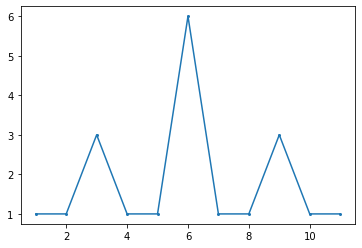

In [35]:
plt.plot(policy,marker='o',ms=2)
#plt.plot(policy_old,marker='o',ms=2)

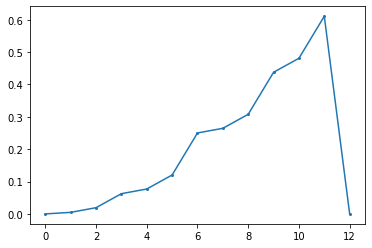

In [36]:
plt.plot(v,marker='o',ms=2)

In [37]:
v_iter = policy_eval_iter(policy, tol = 1e-6, max_iter = 1e6)
v_lineq = policy_eval_lineq(policy)

In [38]:
v_iter

array([0.        , 0.00480765, 0.01923074, 0.0625    , 0.07692303,
       0.12019227, 0.25      , 0.26442301, 0.30769226, 0.4375    ,
       0.48076919, 0.61057689, 0.        ])

In [39]:
v_lineq

array([0.        , 0.00480769, 0.01923077, 0.0625    , 0.07692308,
       0.12019231, 0.25      , 0.26442308, 0.30769231, 0.4375    ,
       0.48076923, 0.61057692, 0.        ])

In [40]:
def value_iteration(tol = 1e-6, max_iter = 1e6):
    v = [0 for s in states]
    
    for iter in tqdm(range(max_iter)):
        err = 0
        for s in states:
            actions = get_actions(s)
            
            # update optimal value function at state s using the value function at other states
            maxq = 0
            for a in actions:
                if a!=None:
                    maxq = max(maxq, get_rewards(s,a) + discount * np.dot(get_transprob(s,a), v))
            
            err = max(err, np.abs(v[s]-maxq))
            v[s] = maxq
        if err < tol:
            break
    
    # Find best policy according to the value function
    policy = [None for s in states]
    for s in states:
        actions = get_actions(s)
        maxq = 0
        for a in actions:
            if a!=None:
                reward = get_rewards(s,a) + discount * np.dot(get_transprob(s,a), v)
                if reward > maxq:
                    maxq = reward
                    policy[s] = [a]
                elif reward == maxq:
                    policy[s].append(a)
    return policy, v

In [41]:
[policy, v] = value_iteration(tol=1e-50, max_iter=100)

 26%|██▌       | 26/100 [00:00<00:00, 1171.61it/s]


In [42]:
policy

[None,
 [1],
 [1, 2],
 [3],
 [1, 2, 4],
 [1, 5],
 [6],
 [1, 5],
 [1, 2, 4],
 [3],
 [1, 2],
 [1],
 None]

ValueError: x, y, and format string must not be None

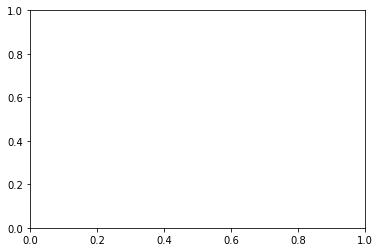

In [28]:
plt.plot(policy,marker='o',ms=2)

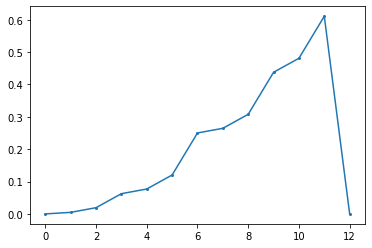

In [43]:
plt.plot(v,marker='o',ms=2)